In [1]:
import os
import yaml

import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm

plt.rcParams['font.family'] = 'Arial'

In [2]:
# read image patch dataframe
main = pd.read_csv(os.path.join(os.getcwd(), 'input/main.csv'))

# isolate tumor-associated clusters
main = main[main['Seg'].isin([0, 1, 2, 8, 10])]

# import markers.csv
markers = pd.read_csv(os.path.join(os.getcwd(), 'input/CRC-097_mcmicro_markers.csv'))

# read SARDANA-097 image contrast settings (defined in CyLinter)
contrast_dir = os.path.join(os.getcwd(), 'input/CRC-097_cylinter_contrast_limits.yml')
contrast_limits = yaml.safe_load(open(contrast_dir))

# read OME-TIFF, segmentation outlines, and H&E channels
tif_path = os.path.join(os.getcwd(), 'input/CRC-097_image.ome.tif')
seg_path = os.path.join(os.getcwd(), 'input/CRC-097_seg_outlines.ome.tif')
he_path = os.path.join(os.getcwd(), 'input/CRC-097_hema_eosin.ome.tif')

# out dir
out = os.path.join(os.getcwd(), f'output/segmentation_tumor')
if not os.path.exists(out):
    os.makedirs(out)

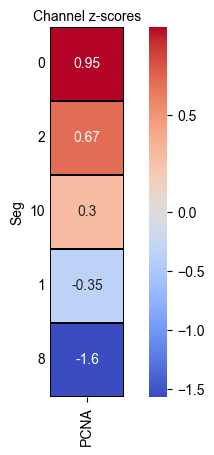

In [3]:
# compute and plot channel z-scores

channels = {
    'PCNA_488': 19
    # 'Keratin_570': 2, 'Ecad_488': 13,
}

antibody_abbrs = {
    'Hoechst0': 'DNA', 'anti_CD3': 'CD3', 'anti_CD45RO': 'CD45RO', 'Keratin_570': 'Keratin', 'aSMA_660': 'aSMA',
    'CD4_488': 'CD4', 'CD45_PE': 'CD45', 'PD1_647': 'PD1', 'CD20_488': 'CD20', 'CD68_555': 'CD68',
    'CD8a_660': 'CD8a', 'CD163_488': 'CD163', 'FOXP3_570': 'FOXP3', 'PDL1_647': 'PDL1',
    'Ecad_488': 'ECAD', 'Vimentin_555': 'Vimentin', 'CDX2_647': 'CDX2', 'LaminABC_488': 'LaminABC',
    'Desmin_555': 'Desmin', 'CD31_647': 'CD31', 'PCNA_488': 'PCNA', 'CollagenIV_647': 'CollagenIV',
}

# compute mean intensity of cells per cluster
clustermap_input = main[list(channels.keys()) + ['Seg']].groupby('Seg').mean()

# compute per channel z-scores across clusters
clustermap_input = (clustermap_input-clustermap_input.mean())/clustermap_input.std()
clustermap_input = clustermap_input.sort_values(by='PCNA_488', ascending=False)

# zero-center colorbar
norm = TwoSlopeNorm(vcenter=0, vmin=clustermap_input.min().min(), vmax=clustermap_input.max().max())

clustermap_object = sns.heatmap(
        clustermap_input, cmap='coolwarm', yticklabels=1, xticklabels=1, square=True,
        linewidths=0.1, linecolor='k', cbar=True, norm=norm, annot=True 
    )

clustermap_object.set_xticklabels(
    [antibody_abbrs[i.get_text()] for i in clustermap_object.get_xticklabels()], rotation=90
)
clustermap_object.set_yticklabels(
    [i.get_text() for i in clustermap_object.get_yticklabels()], rotation=0
)

plt.title('Channel z-scores', y=0.995, fontsize=10)
clustermap_object.yaxis.set_tick_params(length=0.05, width=0.01)
plt.savefig(os.path.join(out, 'channel_z-scores.pdf'), bbox_inches='tight')
plt.show()